# HW2: Local Planning

### EECE 5550: Mobile Robotics (Spring 2024)


**Collaboration Statement:**

In [1]:
# Fill this in per the syllabus, or we will assign a zero to this assignment.

# Installation

This semester, we will use a custom simulator, called `gym-neu-racing`, to develop navigation algorithms. We implemented the basic structure of this simulator for you, and the HW assignments will ask you to implement important functions (e.g., kinematics, sensing, planning, mapping).

To install the simulator, you can use this command (it will download the latest code from GitLab and automatically install it in the environment your Colab notebook runs in):

In [2]:
!pip install git+https://gitlab.com/neu-autonomy/gym-neu-racing.git

  Cloning https://gitlab.com/neu-autonomy/gym-neu-racing.git to c:\users\sarve\appdata\local\temp\pip-req-build-58gtx_54
  Resolved https://gitlab.com/neu-autonomy/gym-neu-racing.git to commit accce6e955894ab920542ee00ef52e28a02b79ef
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://gitlab.com/neu-autonomy/gym-neu-racing.git 'C:\Users\sarve\AppData\Local\Temp\pip-req-build-58gtx_54'


Now that the simulator and its dependencies have been installed, you can import the modules you'll need for this assignment:

In [3]:
import gymnasium
import numpy as np
import gym_neu_racing
from gymnasium import spaces
from gym_neu_racing.envs.wrappers import StateFeedbackWrapper
import matplotlib.pyplot as plt
from typing import Callable
import matplotlib.cm as cmx
import matplotlib.colors as colors
from gym_neu_racing import motion_models
import cvxpy as cp

ModuleNotFoundError: No module named 'cvxpy'

# Problem 1: MPPI

## 1a) MPPI to move toward a goal coordinate

In this problem, you'll implement a basic version of MPPI and show that it outputs a good rollout to move a robot toward a given goal position. This part uses the Unicycle kinematic model that's built into the simulator. You should  make sure that your `get_action` method considers the control limits (otherwise it may command things that the robot can't execute), which may require passing those as arguments to the `__init__` method.

You will probably need to experiment with different numbers of rollouts, cost functions, λ values, numbers of iterations, etc. to get good performance.

Keeping this code relatively organized and clean will help for later parts in the assignment, where you build on this implementation. For example, you are encouraged to define helper methods in your `MPPI` class to help keep your code organized (e.g., you may want a `score_rollouts` and/or `plot_rollouts` method that get called inside the `get_next_action` method).

**Deliverables**:
- Implement the `MPPI` class, in particular the `get_next_action` method, so that the chosen rollout drives the robot toward the goal position.
- Print the best control sequence your MPPI algorithm came up with (the first row/element of this sequence should be the action that your `get_action` returns)
- Include a plot that shows the rollouts, start position, goal position, and highlights the best rollout in that iteration, for at least a few iterations. We expect that the later iterations will give much better rollouts than the first iteration. You should make your axes have the same scale (e.g., using `plt.axis('equal')`).

In [ ]:
# Create an instance of the mobile robot simulator we'll use this semester
env = gymnasium.make("gym_neu_racing/NEUEmptyWorld-v0")

# Tell the simulator to directly provide the current state vector (no sensors yet)
env = StateFeedbackWrapper(env)

In [ ]:
class MPPI:
    def __init__(
        self,
        motion_model,
        num_samples=100,
        horizon=25,
        dt=0.1,
        lambda_=1.0,
        control_limits=np.array([[-1, -0.5], [1, 0.5]]),  # Assuming [min_velocity, min_steering], [max_velocity, max_steering]
        goal_threshold=0.1
    ):
        self.motion_model = motion_model
        self.num_samples = num_samples
        self.horizon = horizon
        self.dt = dt
        self.lambda_ = lambda_
        self.control_limits = control_limits
        self.goal_threshold = goal_threshold

    def get_next_action(self, initial_state: np.ndarray, goal_pos: np.ndarray):
        best_cost = np.inf
        best_action = None
        best_trajectory = None
        trajectories = []

        for _ in range(self.num_samples):
            controls = np.random.uniform(self.control_limits[0], self.control_limits[1], (self.horizon, 2))
            state = initial_state.copy()
            trajectory = [state]
            cost = 0
            for control in controls:
                next_state = self.motion_model.step(state, control, self.dt)
                trajectory.append(next_state)
                cost += self.cost_function(next_state[:2], goal_pos)
                state = next_state

            trajectories.append(np.array(trajectory))
            if cost < best_cost:
                best_cost = cost
                best_action = controls[0]
                best_trajectory = trajectory

        self.plot_rollouts(initial_state, goal_pos, trajectories, np.array(best_trajectory))
        return best_action

    def cost_function(self, state, goal):
        return np.linalg.norm(state - goal)

    def plot_rollouts(self, start_pos, goal_pos, rollouts, best_rollout):
        plt.figure(figsize=(10, 8))
        cmap = plt.get_cmap('viridis')
        cNorm = colors.Normalize(vmin=0, vmax=len(rollouts))
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

        for i, rollout in enumerate(rollouts):
            colorVal = scalarMap.to_rgba(i)
            plt.plot(rollout[:, 0], rollout[:, 1], color=colorVal, alpha=0.4)

        plt.plot(best_rollout[:, 0], best_rollout[:, 1], 'r-', linewidth=2, label='Best Rollout')
        plt.plot(start_pos[0], start_pos[1], 'go', markersize=10, label='Start Position')
        plt.plot(goal_pos[0], goal_pos[1], 'bx', markersize=10, label='Goal Position')
        plt.axis('equal')
        plt.legend()
        plt.title('MPPI Rollouts')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.grid(True)
        plt.show()

You can use the following code to check whether your MPPI implementation is working. After tuning your algorithm, it should be able to come up with a rollout that ends close to the goal (within 0.1m in l2 distance is close enough):

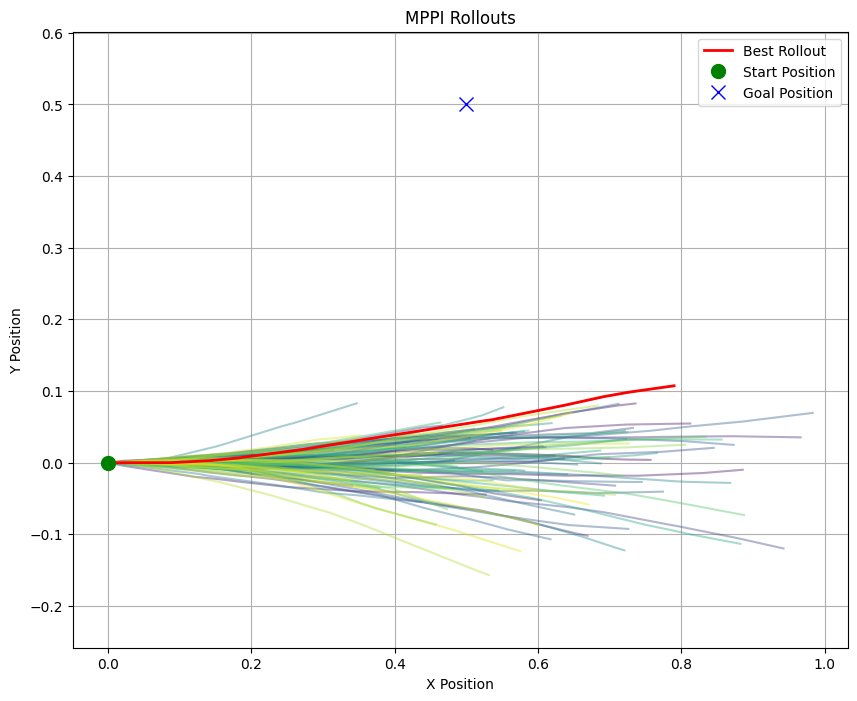

Best initial action: [0.87572875 0.12114033]


In [ ]:
# Initialize the environment (and set random seed so any randomness is repeatable)
np.random.seed(0)
obs, _ = env.reset()

# Set the starting state (x, y, theta) and goal position (x, y).
initial_state = np.array([0.0, 0.0, 0.0])
goal_pos = np.array([0.5, 0.5])

# Instantiate your contoller class
motion_model = motion_models.Unicycle()
controller = MPPI(motion_model=motion_model)

# Run your control algorithm for 1 step. We'll worry about running your
# algorithm in closed-loop in later parts of the assignment.
action = controller.get_next_action(initial_state, goal_pos)
print(f"Best initial action: {action}")

## 1b) MPPI to drive around a racetrack

Now you will extend your MPPI implementation so that your robot drives around a racetrack. There are a few interesting challenges you'll need to figure out that didn't appear in the earlier problem:

*   How to score rollouts? Some possible ideas include placing waypoints around the track, designing a cost-to-go function, or encouraging the vehicle to maintain full speed, but this is completely up to you!
*   How to ensure the robot doesn't collide with the walls? You can transform coordinates from the world frame to map cell indices using `self.static_map.world_coordinates_to_map_indices(states_in_world)` and `self.static_map.static_map[map_indices]` to check whether a cell of the map is occupied or free.

**Deliverables**:
- Implement the `MPPIRacetrack` class below to enable your robot to complete a full lap around the track
- Generate a plot of the path taken with some indication of time (e.g., using a colorbar, timestamps every so often along the path, or another creative way you come up with)

In [ ]:
# Create an instance of the mobile robot simulator we'll use this semester
env = gymnasium.make("gym_neu_racing/NEURacing-v0")

# Tell the simulator to directly provide the current state vector (no sensors yet)
env = StateFeedbackWrapper(env)

In [ ]:
class MPPIRacetrack:
    def __init__(
        self,
        static_map,
        motion_model=motion_models.Unicycle(),
        num_samples=100,
        horizon=25,
        dt=0.1,
        lambda_=1.0,
        control_limits=np.array([[-1, -0.5], [1, 0.5]]),
        collision_penalty=1000,
        goal_threshold=0.1
    ):
        self.motion_model = motion_model
        self.static_map = static_map
        self.num_samples = num_samples
        self.horizon = horizon
        self.dt = dt
        self.lambda_ = lambda_
        self.control_limits = control_limits
        self.collision_penalty = collision_penalty
        self.goal_threshold = goal_threshold

    def get_action(self, initial_state: np.ndarray):
        best_cost = np.inf
        best_action = None

        for _ in range(self.num_samples):
            controls = np.random.uniform(self.control_limits[0], self.control_limits[1], (self.horizon, 2))
            state = initial_state.copy()
            cost = 0
            for control in controls:
                next_state = self.motion_model.step(state, control, self.dt)
                if self.check_collision(next_state):
                    cost += self.collision_penalty
                    break
                cost += self.cost_function(next_state)
                state = next_state

            if cost < best_cost:
                best_cost = cost
                best_action = controls[0]

        return best_action

    def check_collision(self, state):
        map_indices = self.static_map.world_coordinates_to_map_indices(state[:2])
        collision_status = self.static_map.static_map[map_indices] == 1
        return collision_status.any()

    def cost_function(self, state):
        return 1

lap completed!
clockwise -> fwd lap completed
In occupied space.


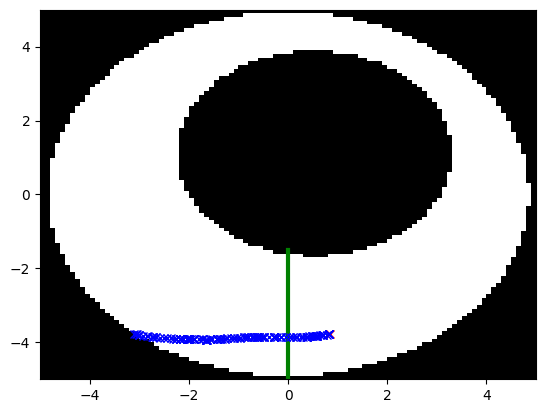

num timesteps used: 142


In [ ]:
def run_planner_on_racetrack(
    env: gymnasium.Env,
    planner_class=MPPIRacetrack,
    seed: int = 0,
    num_laps: int = 3,
) -> int:

    np.random.seed(seed)
    obs, _ = env.reset()
    env.unwrapped.laps_left = num_laps

    # Create an instance of your planner
    planner = planner_class(static_map=env.unwrapped.map)

    # Draw a map of the environment with the finish line + initial position
    ax = env.unwrapped.map.draw_map(show=False)
    ax.plot(
        env.unwrapped.finish_line[:, 0],
        env.unwrapped.finish_line[:, 1],
        "g",
        lw=3,
    )
    ax.plot(obs[0], obs[1], "rx")

    # Run the environment for num_timesteps, unless the robot hits an obstacle
    # or successfully completes the number of laps needed
    num_timesteps = 500
    success = False
    for t in range(num_timesteps):
        action = planner.get_action(obs)
        obs, _, terminated, _, _ = env.step(action)

        ax.plot(obs[0], obs[1], "bx")

        if terminated:
            success = True
            break

    num_timesteps_used = t

    plt.show()

    if success:
        return num_timesteps_used
    else:
        return -1


seed = 0
num_laps = 3
planner_class = MPPIRacetrack
num_timesteps_used = run_planner_on_racetrack(
    env, planner_class=planner_class, seed=seed, num_laps=num_laps
)
print(f"num timesteps used: {num_timesteps_used}")

## [Extra Credit] 1c) Compete for the fastest lap time

In this part, you can earn extra credit by achieving faster lap times (measured in average number of steps to complete the course, not computational runtime). You can get some extra credit by implementing a working version of something interesting here (e.g., another planning algorithm, a learning-based method, an extension beyond the basic MPPI we discussed in class). We will give additional extra credit to the student with the fastest lap time, which can be monitored on the Gradescope leaderboard.

In [ ]:
class BetterPlanner:
    def __init__(self, static_map):
        self.static_map = static_map
        self.horizon = 25

    def get_action(self, obs: np.ndarray) -> np.ndarray:
        action = np.array([0.0, 0.0])

        return action

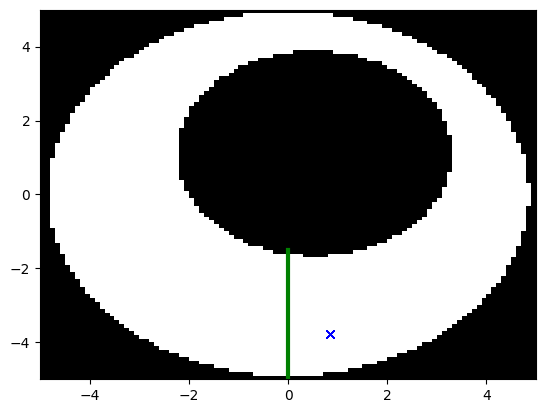

-1

In [ ]:
seed = 0
num_laps = 3
planner_class = BetterPlanner
run_planner_on_racetrack(
    env, planner_class=planner_class, seed=seed, num_laps=num_laps
)

# Problem 2: Trajectory Optimization with `cvxpy`

## 2a) Double Integrator: Initial & Terminal Conditions

For this problem, you'll use the 2D discrete-time double integrator dynamics, where $$\mathbf{x}[t] = \begin{bmatrix}
x[t]\\
y[t]\\
v_x[t]\\
v_y[t]\\
\end{bmatrix}, \quad \mathbf{u}[t] = \begin{bmatrix} a_x[t]\\ a_y[t]\\ \end{bmatrix}, \quad \mathbf{x}[t+dt] = A \mathbf{x}[t] +  B \mathbf{u}[t], \quad A = \begin{bmatrix}
1 & 0 & dt & 0 \\
0 & 1 & 0 & dt \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}, \quad B = \begin{bmatrix}
\frac{dt^2}{2} & 0 \\
0 & \frac{dt^2}{2} \\
dt & 0 \\
0 & dt \\
\end{bmatrix}.
$$

You should turn the following optimization problem into code:

$$
\begin{align}
\min_{x_{0:T}, u_{0:T}}\quad & (x[T] - g_x)^2 + (y[T] - g_y)^2 \\
\text{s.t.}\quad & \mathbf{x}[t+1] = A \mathbf{x}[t] + B \mathbf{u}[t] \quad \forall t \in \{0, 1, \ldots, T-1\} \\
& \mathbf{u}[t] \in U \quad \forall t \in \{0, 1, \ldots, T-1\} \\
& \mathbf{x}[0] = \mathbf{x}_0 \\
& v_x[T] = v_{x,T} \\
& v_x[T] = v_{y,T} \\
\end{align}
$$

with $g_x = 3, g_y=5, v_{x,T}=0, v_{y,T}=0, \mathbf{x}_0 = [1, 2, 0, 0], U = [-1, 1] \times [-1, 1], T=10$.

**Deliverables**:
- Implement `optimize_trajectory`, which will take in initial and terminal conditions, control limits, dt, and return the optimal sequence of states (i.e., an array of shape (T+1, 4) -- T+1 timesteps (T timesteps + the initial state) and 4 states per timestep)
- Generate a plot of your optimal trajectory. You are welcome to use the `plot_trajectory` function or write your own version.

In [ ]:
def optimize_trajectory(initial_pos, initial_vel, goal_pos, goal_vel, u_limits, dt):
    T = 10
    n_states = 4
    n_inputs = 2

    A = np.array([[1, 0, dt, 0],
                  [0, 1, 0, dt],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])

    B = np.array([[dt**2/2, 0],
                  [0, dt**2/2],
                  [dt, 0],
                  [0, dt]])

    x = cp.Variable((T+1, n_states))
    u = cp.Variable((T, n_inputs))  

    x0 = np.concatenate((initial_pos, initial_vel))
    xT = np.concatenate((goal_pos, goal_vel))

    cost = cp.sum_squares(x[-1, :2] - goal_pos)

    constraints = [x[0] == x0]
    constraints += [x[T] == xT] 

    for t in range(T):
        constraints += [x[t + 1] == A @ x[t] + B @ u[t]]
        constraints += [u[t] >= u_limits[:, 0], u[t] <= u_limits[:, 1]]  

    problem = cp.Problem(cp.Minimize(cost), constraints)
    problem.solve()

    if problem.status not in ["infeasible", "unbounded"]:
        optimal_states = x.value
        return optimal_states
    else:
        raise ValueError("The optimization problem was not solved successfully.")

    return None

def plot_trajectory(xt):
    plt.plot(xt[:, 0], xt[:, 1], "-x")
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Trajectory')
    plt.axis("equal")
    plt.grid(True)
    plt.show()

You can check whether your code works using

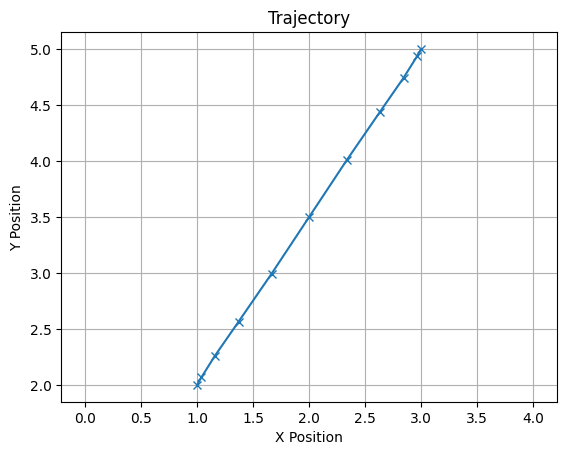

In [ ]:
initial_pos = np.array([1.0, 2.0])
initial_vel = np.array([0.0, 0.0])
goal_pos = np.array([3.0, 5.0])
goal_vel = np.array([0.0, 0.0])
u_limits = 0.2 * np.array([[-1.0, 1.0], [-1.0, 1.0]])
dt = 1.0

optimal_xt = optimize_trajectory(
    initial_pos,
    initial_vel,
    goal_pos,
    goal_vel,
    u_limits,
    dt,
)

plot_trajectory(optimal_xt)

## [Extra Credit] 2b) Incorporate obstacle avoidance as a convex optimization problem

Now, you should extend your optimization code to handle a list of circular obstacles that the double integrator must avoid. We would like you to try to keep this as a convex optimization problem. If you just start adding constraints and costs, you will likely end up with a non-convex optimization problem, which are generally hard to solve.

One possible way to keep the problem convex could be to break the free (i.e., non-obstacle) space into a set of convex regions, then split the trajectory into multiple segments (each one needing to stay within one convex region). But, there could be many other ways, and you are encouraged to try different strategies!


In [ ]:
def optimize_trajectory_with_obstacles(initial_pos, initial_vel, goal_pos, goal_vel, u_limits, dt, obstacles):
    T = 10  # Time horizon
    n_states = 4  # Number of states
    n_inputs = 2  # Number of inputs

    # System matrices
    A = np.array([[1, 0, dt, 0],
                  [0, 1, 0, dt],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    B = np.array([[dt**2/2, 0],
                  [0, dt**2/2],
                  [dt, 0],
                  [0, dt]])

    # Decision variables
    x = cp.Variable((T+1, n_states))
    u = cp.Variable((T, n_inputs))

    # Cost function
    cost = cp.sum_squares(x[-1, :2] - goal_pos)

    # Constraints
    constraints = [x[0] == np.concatenate((initial_pos, initial_vel))]
    constraints += [x[T] == np.concatenate((goal_pos, goal_vel))]
    for t in range(T):
        constraints += [x[t + 1] == A @ x[t] + B @ u[t]]
        constraints += [cp.norm(u[t], 'inf') <= u_limits[0, 1]]

    # Obstacle avoidance constraints
    for obstacle in obstacles:
        for t in range(T+1):
            # For each obstacle, add a constraint that the state at time t is outside the obstacle radius
            constraints += [cp.norm(x[t, :2] - obstacle[:2], 2) >= obstacle[2]]

    # Problem definition
    problem = cp.Problem(cp.Minimize(cost), constraints)

    # Solve the problem
    problem.solve()

    # Verify if the problem was solved
    if problem.status in ["infeasible", "unbounded"]:
        # If the problem is not solved successfully, return None instead of raising an error
        return None

    # Return the optimal trajectory
    return x.value

def plot_trajectory_with_obstacles(xt, obstacles):
    fig, ax = plt.subplots()
    ax.plot(xt[:, 0], xt[:, 1], "-x")
    for obstacle in obstacles:
        circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='r', alpha=0.5)
        ax.add_artist(circle)
    ax.set_aspect('equal', 'box')
    plt.show()

In [ ]:
initial_pos = np.array([1.0, 2.0])
initial_vel = np.array([0.0, 0.0])
goal_pos = np.array([3.0, 5.0])
goal_vel = np.array([0.0, 0.0])
u_limits = 0.2 * np.array([[-1.0, 1.0], [-1.0, 1.0]])
dt = 1.0

obstacles = [
    (1.5, 2.5, 0.5),
    (2.0, 3.5, 0.25),
    (2.5, 4.0, 0.5),
]

optimal_xt = optimize_trajectory_with_obstacles(
    initial_pos,
    initial_vel,
    goal_pos,
    goal_vel,
    u_limits,
    dt,
    obstacles,
)

if optimal_xt is not None:
    plot_trajectory_with_obstacles(optimal_xt, obstacles)
else:
    print("The optimization problem was not solved successfully.")

DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
0.5 <= Pnorm(var6966[0, 0:2] + -[1.5 2.5], 2) , because the following subexpressions are not:
|--  0.5 <= Pnorm(var6966[0, 0:2] + -[1.5 2.5], 2)
0.5 <= Pnorm(var6966[1, 0:2] + -[1.5 2.5], 2) , because the following subexpressions are not:
|--  0.5 <= Pnorm(var6966[1, 0:2] + -[1.5 2.5], 2)
0.5 <= Pnorm(var6966[2, 0:2] + -[1.5 2.5], 2) , because the following subexpressions are not:
|--  0.5 <= Pnorm(var6966[2, 0:2] + -[1.5 2.5], 2)
0.5 <= Pnorm(var6966[3, 0:2] + -[1.5 2.5], 2) , because the following subexpressions are not:
|--  0.5 <= Pnorm(var6966[3, 0:2] + -[1.5 2.5], 2)
0.5 <= Pnorm(var6966[4, 0:2] + -[1.5 2.5], 2) , because the following subexpressions are not:
|--  0.5 <= Pnorm(var6966[4, 0:2] + -[1.5 2.5], 2)
0.5 <= Pnorm(var6966[5, 0:2] + -[1.5 2.5], 2) , because the following subexpressions are not:
|--  0.5 <= Pnorm(var6966[5, 0:2] + -[1.5 2.5], 2)
0.5 <= Pnorm(var6966[6, 0:2] + -[1.5 2.5], 2) , because the following subexpressions are not:
|--  0.5 <= Pnorm(var6966[6, 0:2] + -[1.5 2.5], 2)
0.5 <= Pnorm(var6966[7, 0:2] + -[1.5 2.5], 2) , because the following subexpressions are not:
|--  0.5 <= Pnorm(var6966[7, 0:2] + -[1.5 2.5], 2)
0.5 <= Pnorm(var6966[8, 0:2] + -[1.5 2.5], 2) , because the following subexpressions are not:
|--  0.5 <= Pnorm(var6966[8, 0:2] + -[1.5 2.5], 2)
0.5 <= Pnorm(var6966[9, 0:2] + -[1.5 2.5], 2) , because the following subexpressions are not:
|--  0.5 <= Pnorm(var6966[9, 0:2] + -[1.5 2.5], 2)
0.5 <= Pnorm(var6966[10, 0:2] + -[1.5 2.5], 2) , because the following subexpressions are not:
|--  0.5 <= Pnorm(var6966[10, 0:2] + -[1.5 2.5], 2)
0.25 <= Pnorm(var6966[0, 0:2] + -[2.  3.5], 2) , because the following subexpressions are not:
|--  0.25 <= Pnorm(var6966[0, 0:2] + -[2.  3.5], 2)
0.25 <= Pnorm(var6966[1, 0:2] + -[2.  3.5], 2) , because the following subexpressions are not:
|--  0.25 <= Pnorm(var6966[1, 0:2] + -[2.  3.5], 2)
0.25 <= Pnorm(var6966[2, 0:2] + -[2.  3.5], 2) , because the following subexpressions are not:
|--  0.25 <= Pnorm(var6966[2, 0:2] + -[2.  3.5], 2)
0.25 <= Pnorm(var6966[3, 0:2] + -[2.  3.5], 2) , because the following subexpressions are not:
|--  0.25 <= Pnorm(var6966[3, 0:2] + -[2.  3.5], 2)
0.25 <= Pnorm(var6966[4, 0:2] + -[2.  3.5], 2) , because the following subexpressions are not:
|--  0.25 <= Pnorm(var6966[4, 0:2] + -[2.  3.5], 2)
0.25 <= Pnorm(var6966[5, 0:2] + -[2.  3.5], 2) , because the following subexpressions are not:
|--  0.25 <= Pnorm(var6966[5, 0:2] + -[2.  3.5], 2)
0.25 <= Pnorm(var6966[6, 0:2] + -[2.  3.5], 2) , because the following subexpressions are not:
|--  0.25 <= Pnorm(var6966[6, 0:2] + -[2.  3.5], 2)
0.25 <= Pnorm(var6966[7, 0:2] + -[2.  3.5], 2) , because the following subexpressions are not:
|--  0.25 <= Pnorm(var6966[7, 0:2] + -[2.  3.5], 2)
0.25 <= Pnorm(var6966[8, 0:2] + -[2.  3.5], 2) , because the following subexpressions are not:
|--  0.25 <= Pnorm(var6966[8, 0:2] + -[2.  3.5], 2)
0.25 <= Pnorm(var6966[9, 0:2] + -[2.  3.5], 2) , because the following subexpressions are not:
|--  0.25 <= Pnorm(var6966[9, 0:2] + -[2.  3.5], 2)
0.25 <= Pnorm(var6966[10, 0:2] + -[2.  3.5], 2) , because the following subexpressions are not:
|--  0.25 <= Pnorm(var6966[10, 0:2] + -[2.  3.5], 2)
0.5 <= Pnorm(var6966[0, 0:2] + -[2.5 4. ], 2) , because the following subexpressions are not:
|--  0.5 <= Pnorm(var6966[0, 0:2] + -[2.5 4. ], 2)
0.5 <= Pnorm(var6966[1, 0:2] + -[2.5 4. ], 2) , because the following subexpressions are not:
|--  0.5 <= Pnorm(var6966[1, 0:2] + -[2.5 4. ], 2)
0.5 <= Pnorm(var6966[2, 0:2] + -[2.5 4. ], 2) , because the following subexpressions are not:
|--  0.5 <= Pnorm(var6966[2, 0:2] + -[2.5 4. ], 2)
0.5 <= Pnorm(var6966[3, 0:2] + -[2.5 4. ], 2) , because the following subexpressions are not:
|--  0.5 <= Pnorm(var6966[3, 0:2] + -[2.5 4. ], 2)
0.5 <= Pnorm(var6966[4, 0:2] + -[2.5 4. ], 2) , because the following subexpressions are not:
|--  0.5 <= Pnorm(var6966[4, 0:2] + -[2.5 4. ], 2)
0.5 <= Pnorm(var6966[5, 0:2] + -[2.5 4. ], 2) , because the following subexpressions are not:
|--  0.5 <= Pnorm(var6966[5, 0:2] + -[2.5 4. ], 2)
0.5 <= Pnorm(var6966[6, 0:2] + -[2.5 4. ], 2) , because the following subexpressions are not:
|--  0.5 <= Pnorm(var6966[6, 0:2] + -[2.5 4. ], 2)
0.5 <= Pnorm(var6966[7, 0:2] + -[2.5 4. ], 2) , because the following subexpressions are not:
|--  0.5 <= Pnorm(var6966[7, 0:2] + -[2.5 4. ], 2)
0.5 <= Pnorm(var6966[8, 0:2] + -[2.5 4. ], 2) , because the following subexpressions are not:
|--  0.5 <= Pnorm(var6966[8, 0:2] + -[2.5 4. ], 2)
0.5 <= Pnorm(var6966[9, 0:2] + -[2.5 4. ], 2) , because the following subexpressions are not:
|--  0.5 <= Pnorm(var6966[9, 0:2] + -[2.5 4. ], 2)
0.5 <= Pnorm(var6966[10, 0:2] + -[2.5 4. ], 2) , because the following subexpressions are not:
|--  0.5 <= Pnorm(var6966[10, 0:2] + -[2.5 4. ], 2)